# Solución problema de clustering
## _Prueba técnica Globant p1_
### Objetvo

En este documento se realiza una exploración base para el problema de clustering del modelo, identificando patrones clave en el comportamiento de las distintas variables. Para desvelar un poco que tipo de aproximación matemática describe mejor el comportamiento de los datos.

### Etapas
- Importar datos unificados
- Revisar características y tipologías
- Transformación de variables no numéricas
- Correlación/heatmaps
- PCA

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import OrdinalEncoder

from Funciones import Explorer

In [2]:
# Decretamos las constantes

DATA_DIR="/home/grupodot/Documentos/Examen_globant/Purchase-Card-Transactions_GLBNT_TESTT/Data/"

In [3]:
# Importamos los datos

expl = Explorer()
df = expl.importar_d(DATA_DIR)
print("La dimensión de la base es: ", df.shape)
df.head()

La dimensión de la base es:  (47803, 13)


,TRANS DATE,TRANS VAT DESC,ORIGINAL GROSS AMT,MERCHANT NAME,CARD NUMBER,TRANS CAC CODE 1,TRANS CAC DESC 1,TRANS CAC CODE 2,TRANS CAC DESC 2,TRANS CAC CODE 3,Directorate,BILLING CUR CODE,Unnamed: 10
0,2015-03-08,VR,35.96,fasthosts internet,************3497,L9Y0,Computing Other,RV3VG,AD Adults Strategy,A00,Adult & Communities,NaN,NaN
1,2015-03-23,VR,12.24,fast key services,************4094,L100,Equip Operational,RV3A7,Hodge Hill Adult Team,A00,Adult & Communities,NaN,NaN
2,2015-03-22,VR,52.45,acocks green 224,************4302,K020,Vehicle Fuel,RV14R,Mobile Night Care Service,A00,Adult & Communities,NaN,NaN
3,2015-03-09,VR,40.66,esso aston way ss,************6316,K020,Vehicle Fuel,RV14R,Mobile Night Care Service,A00,Adult & Communities,NaN,NaN
4,2015-03-29,VR,59.57,esso aston way ss,************1287,K020,Vehicle Fuel,RV14R,Mobile Night Care Service,A00,Adult & Communities,NaN,NaN


In [4]:
# Exploración de formato y completitud

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47803 entries, 0 to 47802
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   TRANS DATE          47803 non-null  datetime64[ns]
 1   TRANS VAT DESC      46888 non-null  object        
 2   ORIGINAL GROSS AMT  47803 non-null  float64       
 3   MERCHANT NAME       47803 non-null  object        
 4   CARD NUMBER         47803 non-null  object        
 5   TRANS CAC CODE 1    47795 non-null  object        
 6   TRANS CAC DESC 1    47795 non-null  object        
 7   TRANS CAC CODE 2    47792 non-null  object        
 8   TRANS CAC DESC 2    47792 non-null  object        
 9   TRANS CAC CODE 3    47790 non-null  object        
 10  Directorate         43844 non-null  object        
 11  BILLING CUR CODE    34467 non-null  object        
 12  Unnamed: 10         3959 non-null   object        
dtypes: datetime64[ns](1), float64(1), object(11)
m

Las 13 variables que tenemos registradas tienen en promedio más de 45.000 datos. Algunas tienen una menor cantidad en variables categóricas como "unnamed" o "billing cur code", más adelante exploraremos un poco mejor estos casos. Se propone un encoding a las variables categóricas, así podremos medir su espectro de salidas y distribución de una manera más visible

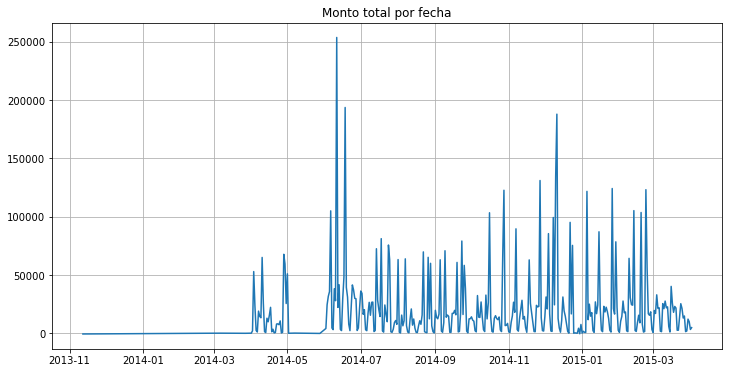

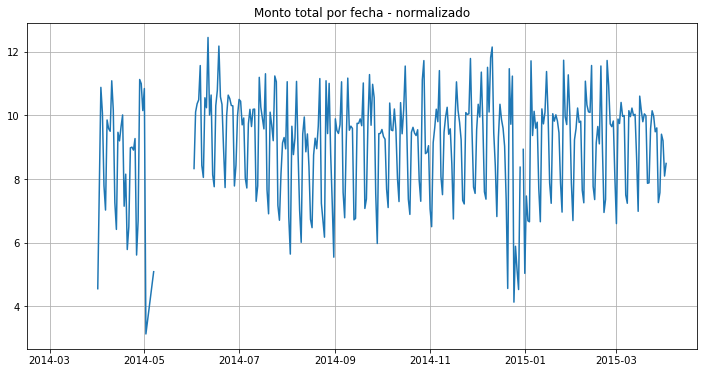

In [5]:
# Revisión de registros en cada periodo y normalizado
expl.graficador(df.groupby(by =["TRANS DATE"]).sum(), tittle="Monto total por fecha")
expl.graficador(np.log(df.groupby(by =["TRANS DATE"]).sum()), tittle="Monto total por fecha - normalizado")

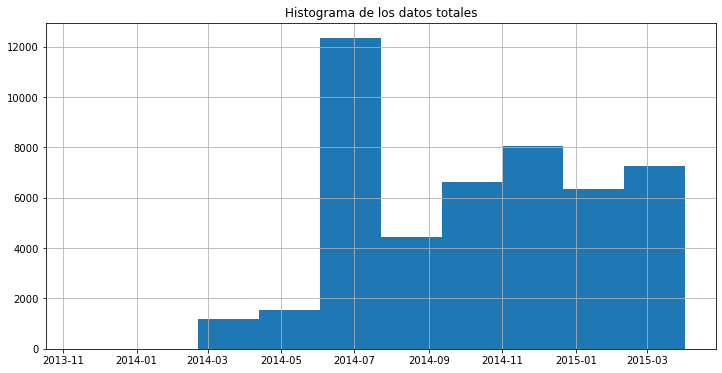

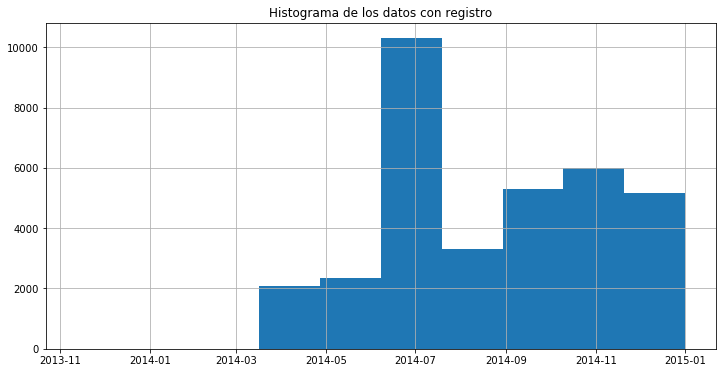

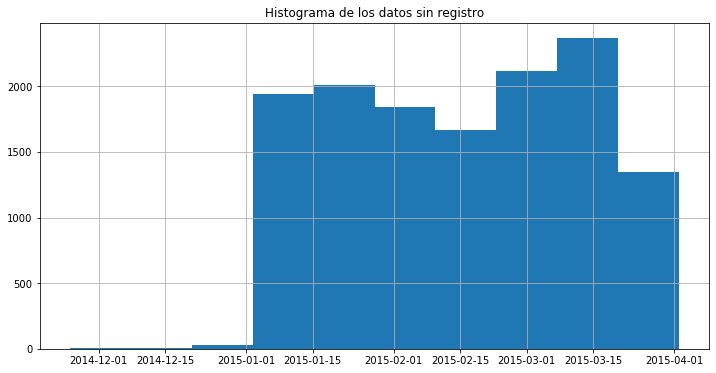

In [6]:
# Revision de registros en cada periodo

expl.graficador((df["TRANS DATE"]), tittle="Histograma de los datos totales", tipo ="hist")
expl.graficador((df[df["BILLING CUR CODE"]=="GBP"]["TRANS DATE"]), tittle="Histograma de los datos con registro", tipo ="hist")
expl.graficador((df[df["BILLING CUR CODE"]!="GBP"]["TRANS DATE"]), tittle="Histograma de los datos sin registro", tipo ="hist")

Existe evidencia de que la mayor consentracion de nulos en la variable de mayor cantidad de nulos se encuentran a partir del 2020, por esto se tomarán los valores nulos como una salida posible y no como un error de medicion 

In [7]:
#creamos un vector con las variables categoricas y eliminamos nan

to_numeric =  (df.select_dtypes(include=["object"]).copy()).columns
df_f = df.fillna("noreg")

In [8]:
#

ord_enc = OrdinalEncoder()
df_f[to_numeric] = ord_enc.fit_transform(df_f[to_numeric])
df_f.describe()

,TRANS VAT DESC,ORIGINAL GROSS AMT,MERCHANT NAME,CARD NUMBER,TRANS CAC CODE 1,TRANS CAC DESC 1,TRANS CAC CODE 2,TRANS CAC DESC 2,TRANS CAC CODE 3,Directorate,BILLING CUR CODE,Unnamed: 10
count,47803.000000,47803.000000,47803.000000,47803.000000,47803.000000,47803.000000,47803.000000,47803.000000,47803.000000,47803.000000,47803.000000,47803.000000
mean,4.571261,158.331458,2297.651905,552.437169,51.877163,54.656967,388.251951,466.267473,0.244211,7.130891,0.278978,9.617304
std,1.550038,1958.036331,1905.590212,304.734431,21.694383,31.078966,250.273340,264.175416,2.062509,3.287610,0.448502,1.439584
min,0.000000,-6794.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.000000,12.700000,289.000000,299.000000,35.000000,28.000000,179.000000,228.000000,0.000000,6.000000,0.000000,10.000000
50%,6.000000,39.980000,1969.000000,572.000000,55.000000,58.000000,280.000000,432.000000,0.000000,6.000000,0.000000,10.000000
75%,6.000000,85.000000,4162.000000,815.000000,60.000000,84.000000,679.000000,717.000000,0.000000,11.000000,1.000000,10.000000
max,7.000000,106289.880000,5986.000000,1060.000000,105.000000,105.000000,911.000000,904.000000,25.000000,13.000000,1.000000,10.000000


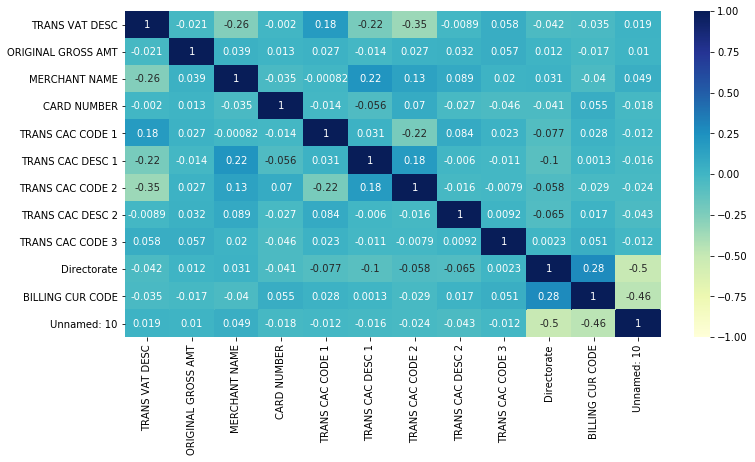

In [9]:
# Correlación de monto con el resto de variables

plt.figure(figsize=(12, 6))
df_f_sample = df_f.sample(1500)
corr_mat = df_f_sample.corr()
sns.heatmap(corr_mat, annot=True, vmin=-1, vmax=1, cmap="YlGnBu")
plt.show()

/home/grupodot/.local/lib/python3.8/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


Text(0.5, 1.0, 'Montos de transacciones -normalizados- en el tiempo')

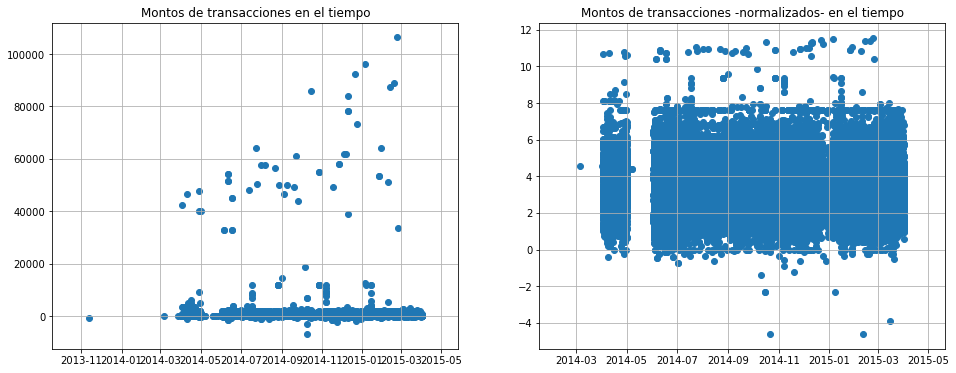

In [10]:
# Como se comportan los montos tranzados en el tiempo

fig, (ax1,ax2) = plt.subplots(1,2, figsize = (16,6))
ax1.scatter(df["TRANS DATE"], (df["ORIGINAL GROSS AMT"]))
ax2.scatter(df["TRANS DATE"], np.log(df["ORIGINAL GROSS AMT"]))
ax1.grid()
ax2.grid()
ax1.set_title("Montos de transacciones en el tiempo")
ax2.set_title("Montos de transacciones -normalizados- en el tiempo")

/usr/lib/python3/dist-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/usr/lib/python3/dist-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


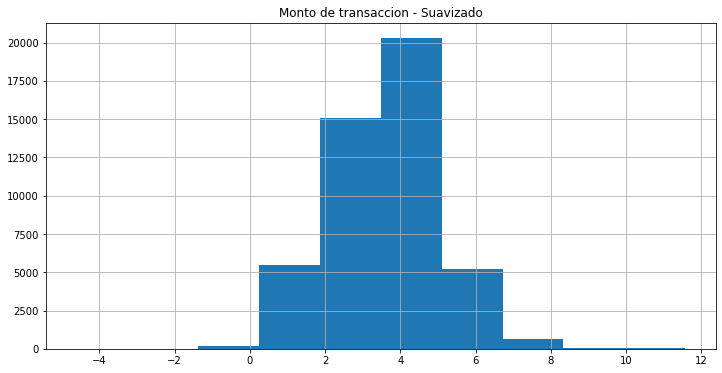

In [11]:
# Como se distribuyen las transacciones

expl.graficador(np.log(df["ORIGINAL GROSS AMT"]), tittle = "Monto de transaccion - Suavizado", tipo = "hist")

In [12]:
# Eliminamos la variable de fechas pues sus efectos parecen ya estar inmersos en otros datos o mediciones y no se evidencian comportamientos ciclicos

dates = df_f["TRANS DATE"]
df_f = df_f.drop(["TRANS DATE"], axis=1)
df_f.head()

,TRANS VAT DESC,ORIGINAL GROSS AMT,MERCHANT NAME,CARD NUMBER,TRANS CAC CODE 1,TRANS CAC DESC 1,TRANS CAC CODE 2,TRANS CAC DESC 2,TRANS CAC CODE 3,Directorate,BILLING CUR CODE,Unnamed: 10
0,3.0,35.96,1379.0,339.0,86.0,17.0,804.0,7.0,0.0,0.0,1.0,10.0
1,3.0,12.24,1376.0,414.0,55.0,28.0,791.0,391.0,0.0,0.0,1.0,10.0
2,3.0,52.45,72.0,451.0,32.0,96.0,764.0,492.0,0.0,0.0,1.0,10.0
3,3.0,40.66,1285.0,668.0,32.0,96.0,764.0,492.0,0.0,0.0,1.0,10.0
4,3.0,59.57,1285.0,139.0,32.0,96.0,764.0,492.0,0.0,0.0,1.0,10.0


matriz de dispercion


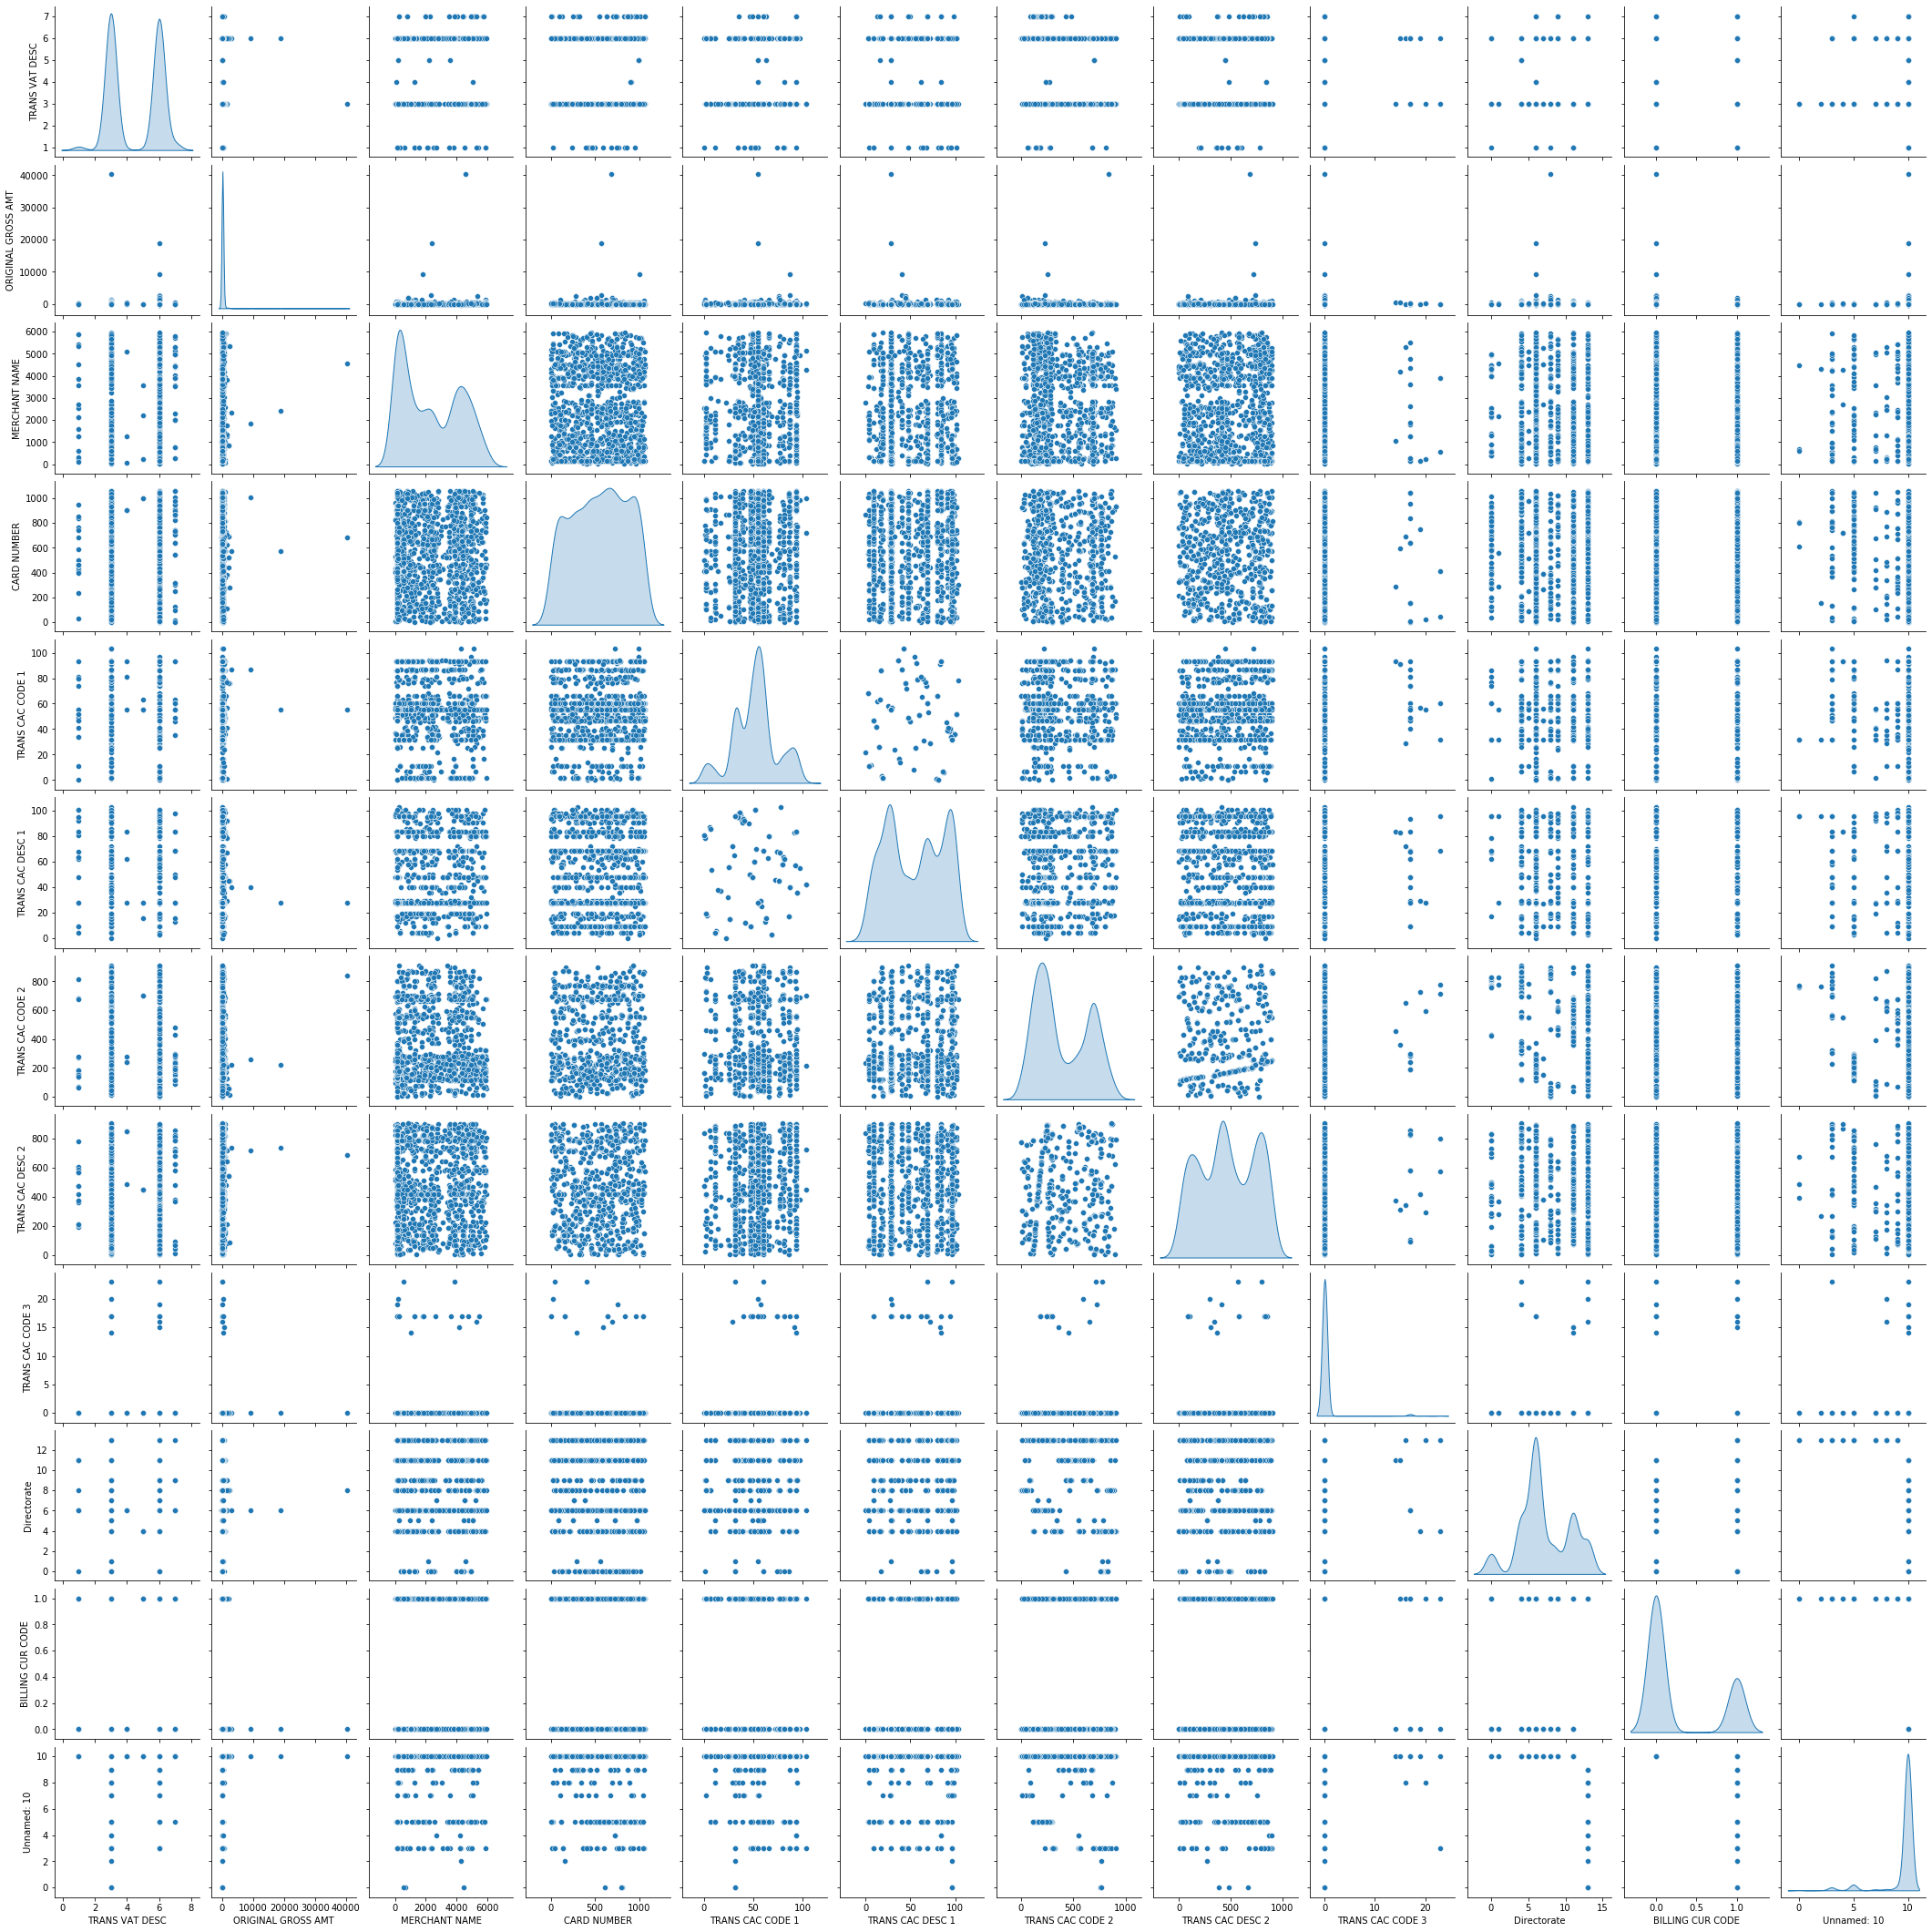

In [13]:
# Quiero ver la correlacion y distribucion de cada variable

print("matriz de dispercion")
sns.pairplot(df_f.sample(1500), diag_kind='kde')
# df_f.hist()

In [14]:
# Escalamos los valores (estandarizados z)

scaler=StandardScaler()
scaler.fit(df_f)
scaled_data=scaler.transform(df_f)

In [15]:
#Creamos una base de datos temporal con los valores estandarizados

t=pd.DataFrame(data=scaled_data, columns=df.columns[1:])
t.describe()

,TRANS VAT DESC,ORIGINAL GROSS AMT,MERCHANT NAME,CARD NUMBER,TRANS CAC CODE 1,TRANS CAC DESC 1,TRANS CAC CODE 2,TRANS CAC DESC 2,TRANS CAC CODE 3,Directorate,BILLING CUR CODE,Unnamed: 10
count,4.780300e+04,4.780300e+04,4.780300e+04,4.780300e+04,4.780300e+04,4.780300e+04,4.780300e+04,4.780300e+04,4.780300e+04,4.780300e+04,4.780300e+04,4.780300e+04
mean,3.127381e-16,8.918387e-18,9.929137e-17,3.626811e-17,5.945591e-19,-8.086004e-17,-1.189118e-17,1.040478e-16,-6.837430e-18,-4.756473e-17,-3.329531e-17,5.707768e-17
std,1.000010e+00,1.000010e+00,1.000010e+00,1.000010e+00,1.000010e+00,1.000010e+00,1.000010e+00,1.000010e+00,1.000010e+00,1.000010e+00,1.000010e+00,1.000010e+00
min,-2.949159e+00,-3.550702e+00,-1.205756e+00,-1.812867e+00,-2.391297e+00,-1.758667e+00,-1.551328e+00,-1.765010e+00,-1.184058e-01,-2.169043e+00,-6.220296e-01,-6.680683e+00
25%,-1.013702e+00,-7.437706e-02,-1.054095e+00,-8.316744e-01,-7.779589e-01,-8.577263e-01,-8.361024e-01,-9.019384e-01,-1.184058e-01,-3.439895e-01,-6.220296e-01,2.658404e-01
50%,9.217537e-01,-6.044459e-02,-1.724691e-01,6.419700e-02,1.439483e-01,1.075669e-01,-4.325394e-01,-1.297162e-01,-1.184058e-01,-3.439895e-01,-6.220296e-01,2.658404e-01
75%,9.217537e-01,-3.745192e-02,9.783675e-01,8.616210e-01,3.744251e-01,9.441543e-01,1.161734e+00,9.491237e-01,-1.184058e-01,1.176888e+00,1.607641e+00,2.658404e-01
max,1.566906e+00,5.420362e+01,1.935561e+00,1.665608e+00,2.448716e+00,1.619860e+00,2.088730e+00,1.656994e+00,1.200288e+01,1.785239e+00,1.607641e+00,2.658404e-01


In [16]:
#Se crea un PCA con salida en 2 componentes principales para poder graficar

pca2=PCA(n_components=2)
pca2.fit(scaled_data)
x_pca=pca2.transform(scaled_data)

/home/grupodot/.local/lib/python3.8/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
No handles with labels found to put in legend.


Text(0.5, 1.0, 'Agrupacion APRIORI')

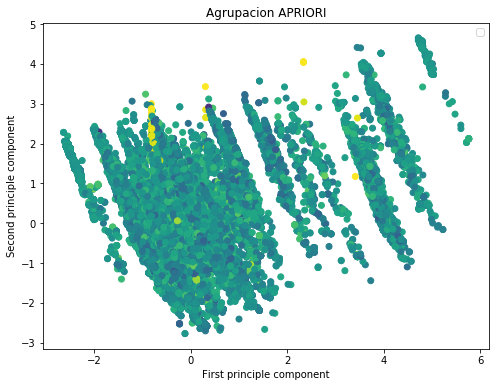

In [17]:
# Segmentamos segun el monto de la transaccion

plt.figure(figsize=(8,6))
plt.scatter(x_pca[:,0],x_pca[:,1],c=np.log(df_f["ORIGINAL GROSS AMT"]))
plt.xlabel('First principle component')
plt.ylabel('Second principle component')
plt.legend()
plt.title("Agrupacion APRIORI")

No parece haber una agrupacion importante facil de encontrar por las dos componentes principales o eigenvectores

In [18]:
# Pruebas sobre la segmentacion

x = df_f.iloc[:, :-1].values
y = df_f.iloc[:, -1].values
x = StandardScaler().fit_transform(x)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.30, random_state=0)

In [19]:
lreg = LogisticRegression()
lreg.fit(x_train, y_train)
y_pred = lreg.predict(x_test)

/home/grupodot/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [20]:
accuracy = accuracy_score(y_test, y_pred) * 100
print("Accuracy of the Logistic Regression Model: ",accuracy)

Accuracy of the Logistic Regression Model:  97.94296074192873


Aparentemente la prediccion de el segmento de cada transaccion parece ser consistente

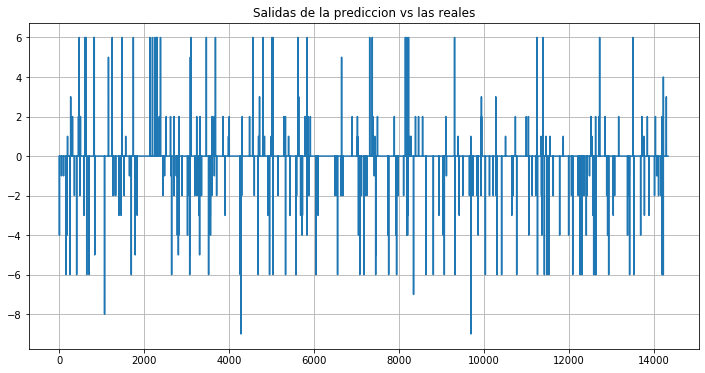

In [29]:
# graficamos el error de la agrupacion por pca

expl.graficador((y_pred-y_test), tittle = "Salidas de la prediccion vs las reales")

Si bien se cumple con el supuesto de la normalidad y la homogeneidad del error en todos los datos, el error llega a medir un valor absoluto del 60% del valor maximo de monto en cada transaccion, esto significa que se deben usar metodologias mas robustas para este estudio.